In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plot 
import scipy.optimize as opt
import os

In [3]:
def load_data(file_path): 
    # load the ODMR data file in to an np array 
    data_array = np.loadtxt(file_path)
    return(data_array)

In [4]:
def load_params(file_path):
    # load in the params data. 
    params_data = pd.read_table(file_path, names = ['Parameter name', 'Parameter value']) 
    return(params_data)

In [5]:
def create_freq_scan(start, stop, step_size):
    # takes the scan parameters from the params data file. 
    step_size_GHz = step_size/1000
    number_of_steps = int((stop-start)/step_size_GHz)+1
    freq = np.linspace(start, stop, number_of_steps)
    return(freq)

In [6]:
 def set_plot_params():
    # formats the plot parameters 
    plot.rcParams.update({'font.size' : 20})
    plot.rcParams.update({'figure.figsize' :[12, 8]})

In [7]:
def plot_heat_map(freq, odmr_data, dwell_time):
    # plot the full ODMR data as a heatmap. 
    number_of_scans = len(odmr_data)
    Y = np.linspace(1, number_of_scans, number_of_scans) 
    
    fig1, ax1 = plot.subplots()
    
    hm = ax1.pcolormesh(freq, Y, odmr_data[:,0:len(freq)], cmap = 'viridis')
    fig1.colorbar(hm, label = '\ncounts per ' + str(np.around(dwell_time*10**6)) + r' $\mu$s')
    ax1.set_xlim(np.min(freq),np.max(freq))
    ax1.set_xticks(np.arange(np.min(freq), np.max(freq), 0.05))
    ax1.set_xlabel('Microwave Frequency (GHz)')
    ax1.set_ylabel('Number of scans')
    ax1.set_title('Heat map of all ODMR data')
    
    return(fig1, ax1)

In [8]:
def demodulate_signal(odmr_data, mod_freq, dwell_time):
    # For lock-in detection to work, I am going to need to demodulate the 
    # signal recorded by multiplying it by a sine wave with a frequency of mod_freq.
    # This is done using the whole line scan, so phase error can creep in. 
    time = np.arange(0, dwell_time*(len(odmr_data[1,:])), dwell_time)
    p0 = [np.mean(odmr_data), mod_freq, np.pi/4, 0]
    x, y = odmr_data.shape
    demod_signal = pd.DataFrame()
    
    for i in range(len(odmr_data)):
        mod_signal_params, confidence = opt.curve_fit(sine_curve, time, odmr_data[i,:], p0)
        mod_signal = sine_curve(time, 1, mod_signal_params[1],
                        mod_signal_params[2], 0)
        
        demod_signal[str(i)] = pd.Series(odmr_data[i,:]*mod_signal)
    
    print(mod_signal_params)
    #fig2, ax2 = plot.subplots()
    #ax2.plot(time[0:100], odmr_data[1,0:100])
    #ax2.plot(time[0:100], mod_signal[0:100])
    return(demod_signal)

In [72]:
def demod_LPF_signal_2_edit(odmr_data, mod_freq, microwave_dwell_time, pixel_dwell_time):
    # I am going to try and correct for the phase error that will arise as a result 
    # of not having the AOM and the microwave generator synched up properly.
    # To account for this, I need to perform a sine curve fit to all the data within a 
    # single microwave frequnecy and then stitch this data together in the end.  
    
    x, y  = odmr_data.shape # get the shape of the ODMR variable.
    time = np.arange(0, pixel_dwell_time*(y), pixel_dwell_time) # a time array value
    p0 = [np.mean(odmr_data)/2, mod_freq, 0, np.mean(odmr_data)/2] # initial parameters
    bounds = ([0, 0, 0, 0],[np.mean(odmr_data), 2*mod_freq, 2*np.pi, np.mean(odmr_data)]) # Set upper limit boundries for trig fittings. 
    point_per_microwave_freq = int(microwave_dwell_time/pixel_dwell_time) # How many pixel values per microwave frequency. 
    y_reduced = int((y-1)/point_per_microwave_freq) # Get the size of the microwave frequnecy array. 
    #lpf_signal_in_phase = np.zeros([y_reduced, x]) # create the low pass filter variable fot he in phase lock-in component. 
    #lpf_signal_quadrature = np.zeros([y_reduced, x]) # Creates the LFP variable for the quadrature.
    lock_in_signal = np.zeros([y_reduced, x]) # Creates a variable for the lock-in signal.
    phase = np.zeros([y_reduced, x]) # create the low pass filter variable.
    
    for j in range(x): # len(x)
        for i in range(y_reduced):
            a = (i+0)*point_per_microwave_freq
            b= ((i+1)*point_per_microwave_freq)-1
            # fit a sine curve to the microwave frequency data.
            mod_signal_params, confidence = opt.curve_fit(sine_curve, time[a:b], 
                                                          odmr_data[j, a:b], p0) 
            mod_signal_sine = sine_curve(time[a:b], 1, mod_signal_params[1], 
                                    mod_signal_params[2], 0) # create the modulation sine wave.

            mod_signal_cos = cos_curve(time[a:b], 1, mod_signal_params[1], 
                                    mod_signal_params[2], 0) # create the modulation cosine wave.
            
            in_phase_signal = odmr_data[j,a:b]*mod_signal_sine # Demodulate the signal
            quadrature_signal = odmr_data[j,a:b]*mod_signal_cos # Demodulate the signal
             # Low pass filter (averaging) in-phase and quadrature and. 
            lpf_signal_in_phase = np.mean(in_phase_signal)
            lpf_signal_quadrature = np.mean(quadrature_signal)
        
            lock_in_signal[i,j] = np.sqrt(np.power(lpf_signal_in_phase,2) + np.power(lpf_signal_quadrature, 2))
            phase[i,j] = np.arctan(lpf_signal_quadrature/lpf_signal_in_phase)

    return(lock_in_signal, phase)

In [10]:
def sine_curve(x, A, f, phi, C):
    # generates a sine curve with a phase offset. 
    # A = amaplitude, f = frequency, phi = phase offest , C = y offset
    y = A*np.sin(2*np.pi*f*x+phi) + C
    return(y)

In [11]:
def cos_curve(x, A, f, phi, C):
    # generates a sine curve with a phase offset. 
    # A = amaplitude, f = frequency, phi = phase offest , C = y offset
    y = A*np.cos(2*np.pi*f*x+phi) + C
    return(y)

In [12]:
def low_pass_filter(demod_signal, mod_freq, microwave_dwell_time, pixel_dwell_time):
    
    # Average over a number of data points to recover the ODMR signal. 
    average_points = int(microwave_dwell_time/pixel_dwell_time)
    lpf_odmr = pd.DataFrame()
    averaged_data = []
    mean_data = np.mean(demod_signal[:,0:len(demod_signal[1,:])-1], axis = 0)
    for i in range(int(len(mean_data)/average_points)):
        averaged_data.append(np.mean(mean_data[i*average_points:(i+1)*average_points-1]))
    averaged_data = pd.DataFrame(averaged_data)
    
    return(averaged_data)

In [13]:
def plot_lpf_signal(start_freq, stop_freq, dwell_time, lpf_odmr,  total_scans): 
    # Plot the demodulated signal as a scatter graph.
    a, b = lpf_odmr.shape
    print(a,b)
    if b == 1:
        mean_lpf_odmr = lpf_odmr
    else:
        mean_lpf_odmr = lpf_odmr.mean(axis = 1)
    
    freq = np.linspace(start_freq, stop_freq, len(mean_lpf_odmr))
    
    fig2, ax2 = plot.subplots()
    ax2.scatter(freq, mean_lpf_odmr, marker = 'x', color = 'k',
               label = 'Lock-in ODMR data')
    ax2.set_xlabel('Microwave Frequency (GHz)')
    ax2.set_ylabel('Counts (per ' + str(round(((dwell_time*10**(6))/2),3)) + r' $\mu$s)')
    ax2.set_title('Lock-in ODMR signal,\nLinescans = ' + str(total_scans))
    ax2.legend(loc = 'lower left')
    
   # lock_in_data = pd.DataFrame([freq, mean_lpf_odmr], columns = ['Frequency (GHz)', 'Lock-in Signal (counts per '+ str(round((dwell_time/2),3)) + r' $\mu$s)'])
    
    return(fig2, ax2, freq)

In [14]:
def drift_check_plot(lpf_odmr, dwell_time):
    # create a plot of the average fluorescence intensity recorded per 
    # line-scan to check for drift in the sample. 
    
    a, b = lpf_odmr.shape
    
    if b == 1:
        mean_fluorescence_per_line = lpf_odmr
    else:
        mean_fluorescence_per_line = lpf_odmr.mean(axis = 0)
    
    scan_array = np.arange(0, len(mean_fluorescence_per_line), 1)
    fig3, ax3 = plot.subplots()
    ax3.scatter(scan_array, mean_fluorescence_per_line, marker = 'x', 
               color='k', label='mean fluorescence \nintensity per line scan')
    ax3.set_xlabel('Line Scan number')
    ax3.set_title('Fluorescent intensity drift over line scans')
    ax3.set_ylabel('Counts (per ' + str(round((dwell_time/2),3)) + r' $\mu$s)')
    ax3.legend(loc='lower left')
    return(fig3, ax3)

In [15]:
def save_data_lock_in(date, file_ID,  experiment, frequency, intensity, dwell_time, fig1, fig2, fig3):
    
    #destination_folder = 'H:\\My Documents\\Strathclyde_Back_up\\Graphs_and_analysis\\ODMR\\' + date + '\\' +'Lock_in_adaptive\\'
    destination_folder = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data Analysis\\Ryans Data (2018-2021)\\ODMR\\' + date + '\\' +'Lock_in_adaptive\\'
    output_data_file = destination_folder + file_ID + '_averaged_results_'+ experiment +'.dat'
    
    # Checking to see if the folder exists in which to save the data, and creating it if it does not
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        # Checking the output file exists and creating and initialising it if not
    
    if os.path.isfile(output_data_file) == False:
        with open(output_data_file, "w") as wf:
            wf.write('Frequency (GHz)' + '\t' + 'Counts (per ' + str(round((dwell_time/2),3)) + r' $\mu$s)' + '\n')
    # Writing contrast dip description to the .dat file
    
    for i in range(len(frequency)):
        with open(output_data_file, "a") as wf:
            wf.write(str(frequency[i]) + " \t"  + str(intensity[i]) + " \n")
        
    # Saving a plot of the raw data to a folder. 
    fig1.savefig(destination_folder + 'plot_' + file_ID + '_' + experiment + '_Heat_Map' + '.png')
    fig1.savefig(destination_folder + 'plot_' + file_ID + '_' + experiment + '_Heat_Map' + '.pdf')

    fig2.savefig(destination_folder + 'plot_' + file_ID + '_' + experiment + '_scatter' + '.png')
    fig2.savefig(destination_folder + 'plot_' + file_ID + '_' + experiment + '_scatter' + '.pdf')

    fig3.savefig(destination_folder + 'plot_' + file_ID + '_' + experiment + '_drift' + '.png')
    fig3.savefig(destination_folder + 'plot_' + file_ID + '_' + experiment + '_drift' + '.pdf')

<ipython-input-7-249b8f03de5e>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hm = ax1.pcolormesh(freq, Y, odmr_data[:,0:len(freq)], cmap = 'viridis')


250 20


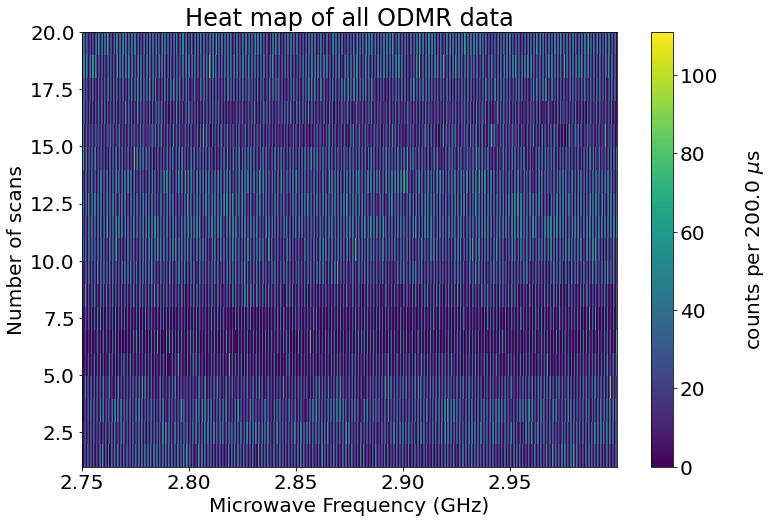

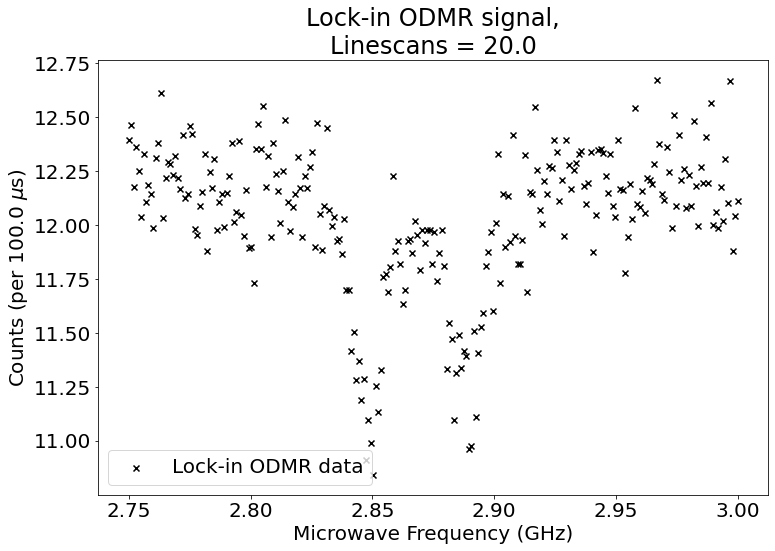

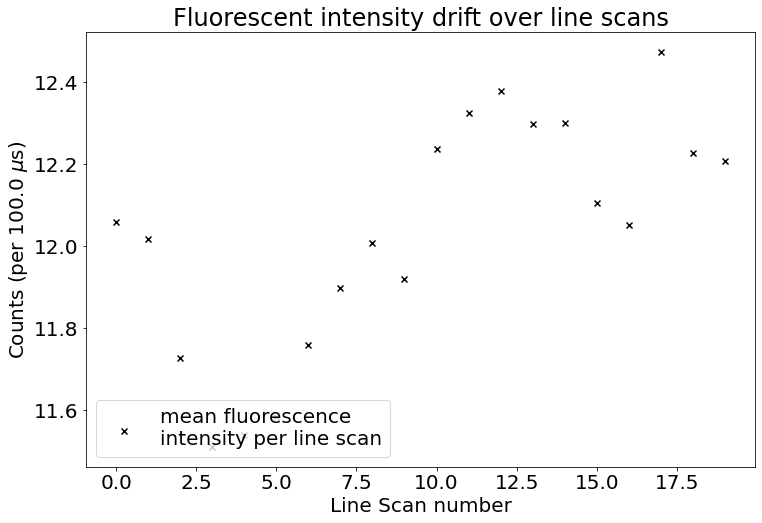

In [73]:
#######
 # This portion of the code produced the ODMR data plotting and the double lorentz fitting and 
 # Saves this data into a text file and the 2 plots generated. 
#######

# Load in the data file into an np array, and freqeuncy scan parameters 
# into a pandas array.
folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\ODMR and imaging\\'
date = '20201125'
file_name = date + '_NVScan_13'

odmr_data = load_data(folder_path + date + '\\' + file_name + '.dat')
params_file = load_params(folder_path + date + '\\' + file_name + 'Params.dat')
params_values = params_file['Parameter value']

# Create the freqeuncy scan array. 
freq = create_freq_scan(params_values[0], params_values[1], params_values[2])

# plot a colour map of the ODMR data and set plot format for the program. 
set_plot_params()

pixel_dwell_time = params_values[3]*10**(-6) # Pixel Dwell time in microseconds
microwave_dwell_time = params_values[6]*10**(-6) # Microwave Dwell time in microseconds
mod_freq = params_values[7] # AOM modulation frequnecy.

fig1, ax1 = plot_heat_map(freq, odmr_data, pixel_dwell_time)

if mod_freq == 0:
    experiment = 'CW_ODMR'
    #mean_odmr = np.mean(odmr_data, axis = 0)
    lpf_odmr = low_pass_filter(odmr_data, mod_freq, microwave_dwell_time, pixel_dwell_time)
    fig2, ax2, freq = plot_lpf_signal(params_values[0], params_values[1], pixel_dwell_time, lpf_odmr, params_values[4])
    fig3, ax3 = drift_check_plot(pd.DataFrame(np.transpose(odmr_data)), pixel_dwell_time*10**(6))
else:
    experiment = 'Lock_in'
    # demodulate the signal
    lpf_odmr, phase = demod_LPF_signal_2_edit(odmr_data, mod_freq, microwave_dwell_time, pixel_dwell_time)
    fig2, ax2, freq = plot_lpf_signal(params_values[0], params_values[1], pixel_dwell_time, lpf_odmr, params_values[4])
    fig3, ax3 = drift_check_plot(lpf_odmr, pixel_dwell_time*10**(6))

#save_data_lock_in(date, file_name, experiment, freq, lpf_odmr.mean(axis = 1), pixel_dwell_time*10**(6), fig1, fig2, fig3)

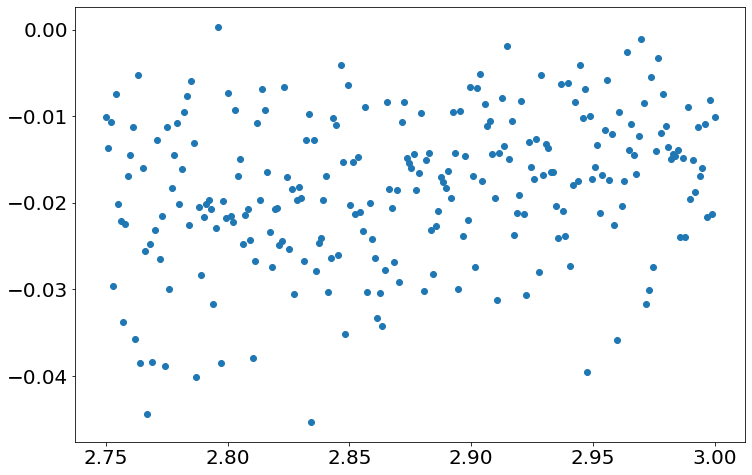

In [75]:
plot.scatter(freq, phase[:,5])